# <u>Image classification: SVM, KNN, Random Forest</u>  <br /> <sub> <span style="font-size:smaller;"> Jullian C.B. Williams </span> </sub> <br /> <sub> <span style="font-size:smaller;"> *Polish Academy of Sciences, Institute of Geophysics, Warsaw, Poland* </span> </sub>


In [ ]:
# !pip install shapely
# !pip install geopandas
# !pip install fiona
# !pip install rasterstats
# !pip install spectral

In [1]:
import random
import warnings
import argparse, os

import numpy as np
import pandas as pd
# from osgeo import ogr
# from osgeo import gdal #<---- to geospatial env
import geopandas as gpd

from PIL import Image

import rasterio as rio
from rasterio.plot import show
from rasterio.plot import show_hist 
from rasterstats import zonal_stats
from rasterio.plot import adjust_band

import seaborn as sns
import matplotlib.image
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

from spectral import *
from sklearn import svm
from scipy import ndimage
from sklearn.svm import SVC
from scipy.stats import entropy
import spectral.io.envi as envi #run PCA
from sklearn.svm import LinearSVC
from skimage import io, transform # from scipy.misc import imresize  <---- here...we...go..
from skimage.morphology import disk #manage disk while running
from skimage.util import img_as_ubyte #Avoid precision loss converting image of type float32 to uint8 as required by rank filters
from skimage.filters.rank import entropy #for GLCM entropy
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from skimage.feature import graycomatrix, graycoprops # from skimage.feature import greycomatrix, greycoprops <--- depreciated or..? lang.
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

## Data exploration

#### Many ways to skin a cat <---- Look at the ways to get class accuracy from methods

In [12]:
# read data from csv file <---- Removing location info for now to run data smoothly
data = pd.read_csv('C:/Users/jullian.williams/Desktop/HIRLOMAP/ROI/merge_W_I_NOLOC.csv')
# print(data)

# splitting data into training and test set
training_set,test_set = train_test_split(data,test_size=0.2,random_state=1)
# print("train:",training_set)
# print("test:",test_set)

In [22]:
# prepare data for applying it to svm
x_train = training_set.iloc[:,0:3].values  # data
y_train = training_set.iloc[:,3].values  # target
x_test = test_set.iloc[:,0:3].values  # data
y_test = test_set.iloc[:,3].values  # target
#print(x_train,y_train)
print(x_test,y_test)

[[-2.59451962e+01 -2.91396084e+01  3.05808868e+01]
 [-2.56060982e+01 -2.99802723e+01  2.97953033e+01]
 [ 5.08488443e+05  8.53714363e+06 -1.11917496e+01]
 [-2.35769997e+01 -2.66587219e+01  2.85540028e+01]
 [-2.39926910e+01 -2.98778553e+01  2.84174232e+01]
 [-2.58651447e+01 -2.86625080e+01  3.04171104e+01]
 [-2.45789833e+01 -2.74654064e+01  2.97955418e+01]
 [-2.76269684e+01 -3.04926586e+01  3.01892643e+01]
 [ 5.03406940e+05  8.53290904e+06 -1.00105972e+01]
 [-2.87978058e+01 -3.00907822e+01  3.03948059e+01]
 [-2.51708717e+01 -2.85938568e+01  3.00240688e+01]
 [ 5.22020708e+05  8.54702126e+06 -1.50727720e+01]
 [ 5.24303702e+05  8.54372565e+06 -1.59655418e+01]
 [-2.80270443e+01 -2.74508057e+01  2.84594173e+01]
 [-2.66429730e+01 -2.81357174e+01  2.98274803e+01]
 [ 5.11839290e+05  8.53644400e+06 -1.05951681e+01]
 [ 5.18154347e+05  8.54197658e+06 -1.15017013e+01]
 [-2.63830357e+01 -2.84733257e+01  2.98345890e+01]
 [ 5.00198780e+05  8.54037020e+06 -1.35469732e+01]
 [ 4.99439317e+05  8.54931346e+

In [23]:
# fitting the data (train a model)
classifier = SVC(kernel='rbf',random_state=1,C=1,gamma='auto')
classifier.fit(x_train,y_train)

# perform prediction on x_test data
y_pred = classifier.predict(x_test)
test_set['prediction']=y_pred
print(y_pred)

# creating confusion matrix and accuracy calculation
cm = confusion_matrix(y_test,y_pred)
print(cm)
accuracy = float(cm.diagonal().sum())/len(y_test)
print('model accuracy is:',accuracy*100,'%')

['water' 'water' 'ice' 'water' 'water' 'water' 'water' 'water' 'ice'
 'water' 'water' 'ice' 'ice' 'water' 'water' 'ice' 'ice' 'water' 'ice'
 'ice' 'ice' 'water' 'water' 'ice' 'ice' 'water' 'water' 'ice' 'ice'
 'water' 'ice' 'water' 'water' 'ice' 'ice' 'ice' 'water' 'water' 'ice'
 'ice' 'ice']
[[19  0]
 [ 1 21]]
model accuracy is: 97.5609756097561 %


Confusion Matrix:
 [[19  0]
 [ 1 21]]


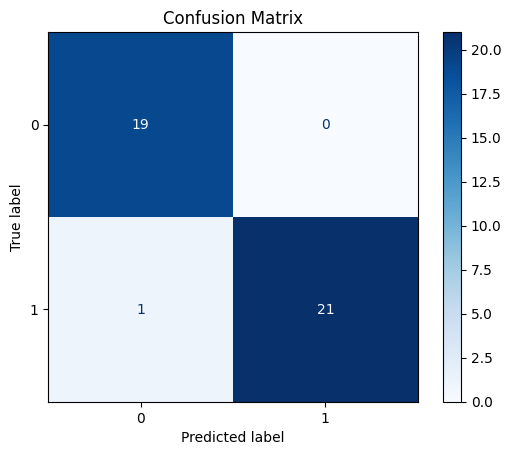

In [64]:
# Compute confusion matrix using test data
cnf_matrix_sklearn = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cnf_matrix_sklearn)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix_sklearn, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [10]:
# read data from csv file
data = pd.read_csv('C:/Users/jullian.williams/Desktop/HIRLOMAP/ROI/merge_W_I_BINNOLOC.csv')
print(data)

        SAMPLE_1_2    SAMPLE_2_2  SAMPLE_3_2  id
0       -26.204203 -2.596121e+01   30.119364   0
1       -24.356628 -2.988782e+01   30.078508   0
2       -27.097809 -2.784318e+01   30.113373   0
3       -25.155590 -2.828107e+01   30.115402   0
4       -25.170872 -2.859386e+01   30.024069   0
..             ...           ...         ...  ..
200  510550.502700  8.545613e+06  -13.522374   1
201  510145.455300  8.545143e+06  -11.678425   1
202  507807.227300  8.544932e+06  -11.342185   1
203  509178.865000  8.545677e+06  -15.110819   1
204  507890.077900  8.543256e+06  -13.570217   1

[205 rows x 4 columns]


In [3]:
# splitting data into training and test set
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,0:3], data.iloc[:, -1], test_size=0.2, random_state=42)

In [8]:
# --- SVM Classifier ---
# Define the SVM classifier with a linear kernel
svm_classifier = svm.SVC(kernel='linear', C=1.0)

# Fit the model on the training data
svm_classifier.fit(X_train, y_train)

# Make predictions on the test data
ypred_svm = svm_classifier.predict(X_test)

# Calculate and print accuracy on the test set for SVM
accuracy_svm = accuracy_score(y_test, ypred_svm)
print(f"SVM Test set accuracy: {accuracy_svm:.4f}")

SVM Test set accuracy: 1.0000


In [12]:
knn_classifier = KNeighborsClassifier(n_neighbors=2)

# Fit the KNN model
knn_classifier.fit(X_train, y_train)

# Make predictions using KNN
ypred_knn = knn_classifier.predict(X_test)

# Calculate and print accuracy for KNN
accuracy_knn = accuracy_score(y_test, ypred_knn)
print(f"KNN Test set accuracy: {accuracy_knn:.4f}")


KNN Test set accuracy: 1.0000


In [13]:
cm = confusion_matrix(y_test,ypred_knn)
print(cm)
accuracy = float(cm.diagonal().sum())/len(y_test)
print('model accuracy is:',accuracy*100,'%')

[[23  0]
 [ 0 18]]
model accuracy is: 100.0 %


In [6]:
# Define the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Fit the model on the training data
dt_classifier.fit(X_train, y_train)

# Make predictions using Decision Tree
ypred_dt = dt_classifier.predict(X_test)

# Calculate and print accuracy for Decision Tree
accuracy_dt = accuracy_score(y_test, ypred_dt)
print(f"Decision Tree Test set accuracy: {accuracy_dt:.4f}")

Decision Tree Test set accuracy: 1.0000


In [14]:
cm = confusion_matrix(y_test,ypred_dt)
print(cm)
accuracy = float(cm.diagonal().sum())/len(y_test)
print('model accuracy is:',accuracy*100,'%')

[[23  0]
 [ 0 18]]
model accuracy is: 100.0 %


#### SVM, KNN & Decision Tree confusion matrix

SVM Confusion Matrix:
 [[23  0]
 [ 0 18]]


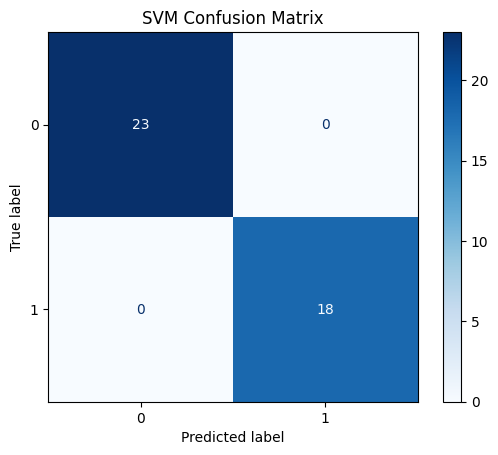

KNN Confusion Matrix:
 [[23  0]
 [ 0 18]]


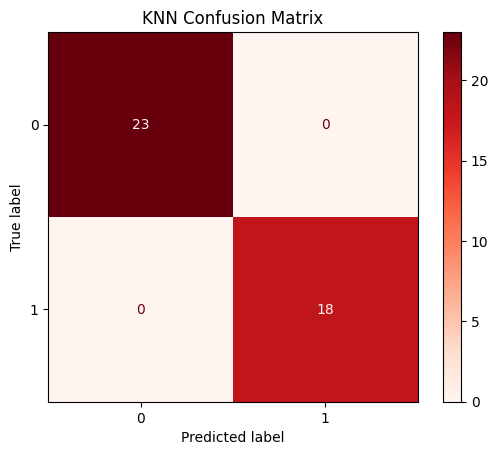

Decision Tree Confusion Matrix:
 [[23  0]
 [ 0 18]]


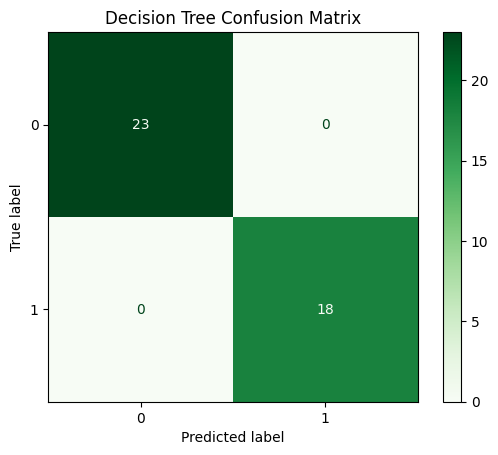

In [7]:
# --- Confusion Matrices ---
# Compute and plot confusion matrix for SVM
cnf_matrix_svm = confusion_matrix(y_test, ypred_svm)
print("SVM Confusion Matrix:\n", cnf_matrix_svm)

disp_svm = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix_svm, display_labels=[0, 1])
disp_svm.plot(cmap=plt.cm.Blues)
plt.title('SVM Confusion Matrix')
plt.show()

# Compute and plot confusion matrix for KNN
cnf_matrix_knn = confusion_matrix(y_test, ypred_knn)
print("KNN Confusion Matrix:\n", cnf_matrix_knn)

disp_knn = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix_knn, display_labels=[0, 1])
disp_knn.plot(cmap=plt.cm.Reds)
plt.title('KNN Confusion Matrix')
plt.show()

# Compute and plot confusion matrix for Decision Tree
cnf_matrix_dt = confusion_matrix(y_test, ypred_dt)
print("Decision Tree Confusion Matrix:\n", cnf_matrix_dt)

disp_dt = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix_dt, display_labels=[0, 1])
disp_dt.plot(cmap=plt.cm.Greens)
plt.title('Decision Tree Confusion Matrix')
plt.show()

In [54]:
# Look at classifier params
classifier = SVC(kernel='rbf',random_state=1,C=1,gamma='auto')
classifier.fit(x_train,y_train)

SVC(C=1, gamma='auto', random_state=1)

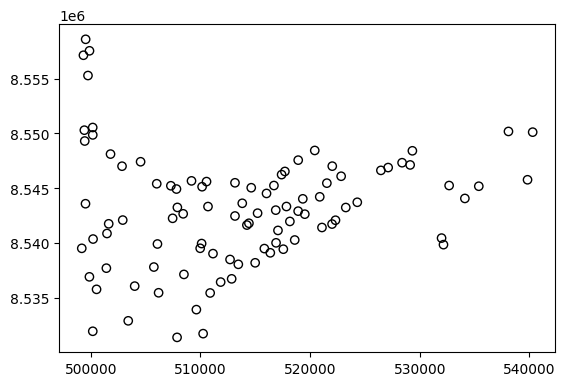

In [12]:
# Just remember to look at data.
tsl_fp = 'C:/Users/jullian.williams/Desktop/HIRLOMAP/ROI/HS_ice_only.shp'
tsl_shp = gpd.read_file(tsl_fp)

# Plot the shape
tsl_shp.plot(edgecolor ='black', facecolor = 'None');

In [13]:
# And to explore it.
source = ogr.Open('C:/Users/jullian.williams/Desktop/HIRLOMAP/ROI/HS_ice_only.shp')
layer = source.GetLayer()
schema = []
ldefn = layer.GetLayerDefn()
for n in range(ldefn.GetFieldCount()):
    fdefn = ldefn.GetFieldDefn(n)
    schema.append(fdefn.name)
print(schema)

['X', 'Y', 'SAMPLE_1_2', 'SAMPLE_2_2', 'SAMPLE_3_2']


In [2]:
# If it's a CSV.
data = pd.read_csv('C:/Users/jullian.williams/Desktop/HIRLOMAP/ROI/merge_W_I_BINNOLOC.csv')
print(data)

        SAMPLE_1_2    SAMPLE_2_2  SAMPLE_3_2  id
0       -26.204203 -2.596121e+01   30.119364   0
1       -24.356628 -2.988782e+01   30.078508   0
2       -27.097809 -2.784318e+01   30.113373   0
3       -25.155590 -2.828107e+01   30.115402   0
4       -25.170872 -2.859386e+01   30.024069   0
..             ...           ...         ...  ..
200  510550.502700  8.545613e+06  -13.522374   1
201  510145.455300  8.545143e+06  -11.678425   1
202  507807.227300  8.544932e+06  -11.342185   1
203  509178.865000  8.545677e+06  -15.110819   1
204  507890.077900  8.543256e+06  -13.570217   1

[205 rows x 4 columns]


In [4]:
# splitting data into training and test set
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,0:3], data.iloc[:, -1], test_size=0.2, random_state=42)

In [109]:
filename = 'C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/ALL_SAT/composite/RS2/3band_/RS2_SCNA_20120203_155203_ASC_001.tif'
src = rio.open(filename)
bands = src.read()
img = src.read(1)
profile = src.profile

In [110]:
dimensions = img.shape
height = img.shape[0]
width = img.shape[1]
channels = bands.shape[0]

print('Image Dimension    : ',dimensions)
print('Image Height       : ',height)
print('Image Width        : ',width)
print('Number of Channels : ',channels)

Image Dimension    :  (561, 901)
Image Height       :  561
Image Width        :  901
Number of Channels :  3


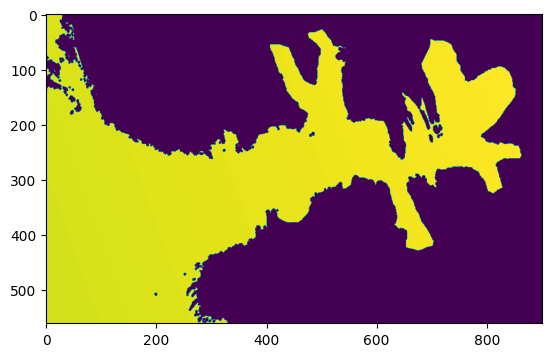

In [111]:
b1 = src.read(1)
b2 = src.read(2)
b3 = src.read(3)
plt.imshow(b1)

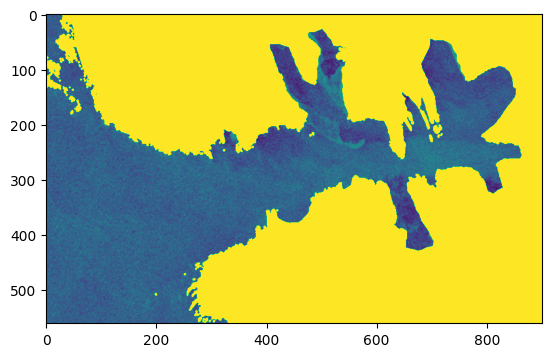

In [7]:
plt.imshow(b2)

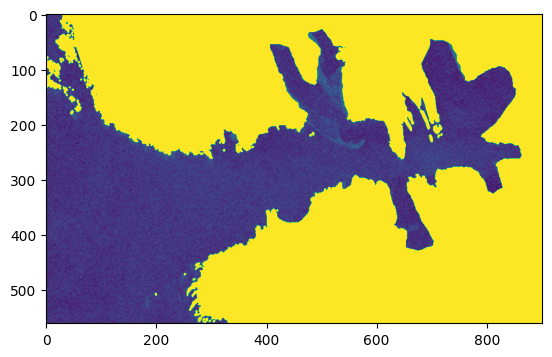

In [8]:
plt.imshow(b3)

In [116]:
bands = np.dstack((b1,b2,b3))  # <-- Why must b1 be alpha? Odd.
bands = bands.reshape(int(np.prod(bands.shape)/3),3)

In [107]:
print(bands)

[[ 35.99509  -15.112477 -27.76305 ]
 [ 35.997776 -14.51249  -25.899967]
 [ 36.000458 -14.601342 -24.910952]
 ...
 [  0.         9.         9.      ]
 [  0.         9.         9.      ]
 [  0.         9.         9.      ]]


In [35]:
# raster_path = "C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/ALL_SAT/composite/RS2/3band_/RS2_SCNA_20120203_155203_ASC_001.tif"
# with rio.open(raster_path) as src:
#     image = src.read()  # Read all bands
#     profile = src.profile  # Save metadata
#     image = np.moveaxis(image, 0, -1)  # Rearrange to (rows, cols, bands)

# # Step 2: Load the shapefile
# shapefile_path = "C:/Users/jullian.williams/Desktop/HIRLOMAP/ROI/HS_ice_water.shp"
# shapefile = gpd.read_file(shapefile_path)

# # Step 3: Extract training data
# # Assuming the shapefile has a 'class' column for labels
# training_data = []
# labels = []

# for _, row in shapefile.iterrows():
#     geom = row.geometry
#     label = row['Class']
#     mask = rio.features.geometry_mask([geom], transform=profile['transform'], invert=True, out_shape=image.shape[:2])
#     pixels = image[mask]
#     training_data.append(pixels)
#     labels.extend([label] * len(pixels))

# training_data = np.vstack(training_data)
# labels = np.array(labels)

# # Step 4: Train the SVM model
# X_train, X_test, y_train, y_test = train_test_split(training_data, labels, test_size=0.3, random_state=42)
# svm = SVC(kernel='rbf', C=1, gamma='scale')  <---------------------- Might be depreciated. Not effective.
# svm.fit(X_train, y_train)

In [36]:
clf = make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-3))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=0, tol=0.001))])

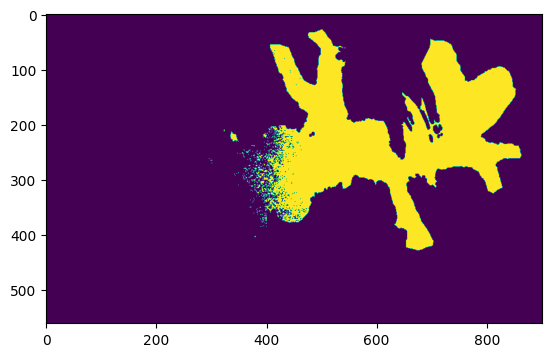

In [40]:
r = clf.predict(bands) #Predict using the model
r = r.reshape(b2.shape)
print(r)
plt.imshow(r)

In [2]:
filename = 'C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/ALL_SAT/composite/RS2/3band_/RS2_SCNA_20120203_155203_ASC_001.tif'
src = rio.open(filename)
meta = src.profile
bands = src.read()
b1 = src.read(1)
b2 = src.read(2)
b3 = src.read(3)

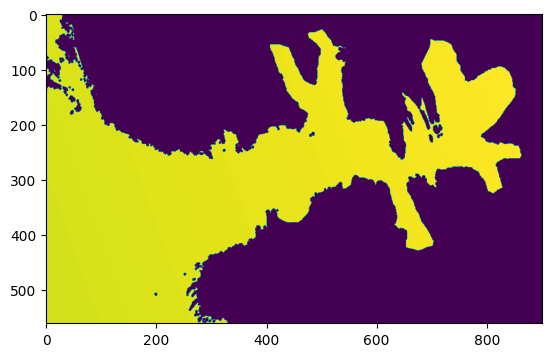

<Axes: >

In [10]:
show(b1)

## Gray level Co-occurence matrices and AI inputs

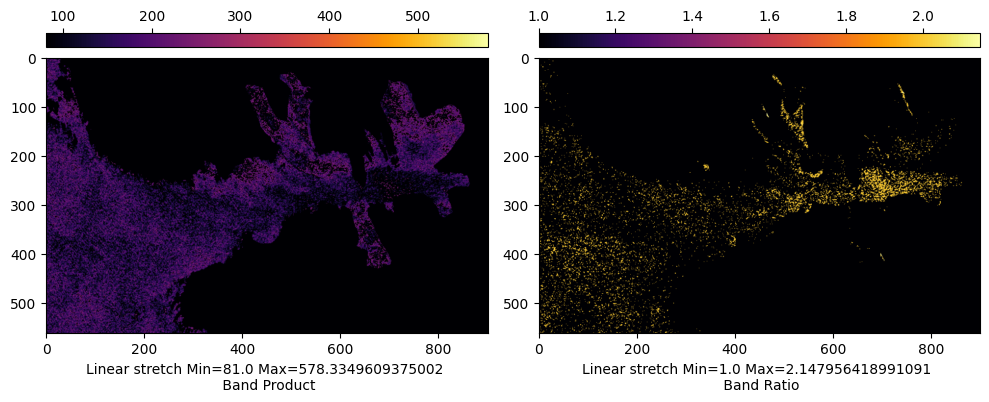

In [18]:
# fig, ax = plt.subplots(figsize=(8,8))
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1_divider = make_axes_locatable(ax1)
ax2_divider = make_axes_locatable(ax2)

prod = b2*b3
rat = b3/b2

vmin1 = np.nanpercentile(prod, 1)
vmax1 = np.nanpercentile(prod, 99)
vmin2 = np.nanpercentile(rat, 1)
vmax2 = np.nanpercentile(rat, 99)

ika = ax1.imshow(Image.fromarray(prod.astype(np.uint8)), cmap='inferno', vmin=vmin1, vmax=vmax1, interpolation = 'bilinear') #fixes NaN problem
ikb = ax2.imshow(Image.fromarray(rat.astype(np.uint8)), cmap='inferno', vmin=vmin2, vmax=vmax2, interpolation = 'bilinear')

ax1.imshow(Image.fromarray(prod.astype(np.uint8)), cmap='inferno', vmin=vmin1, vmax=vmax1, interpolation = 'bilinear') #fixes NaN problem
cax1 = ax1_divider.append_axes("top", size="5%", pad="4%")
cb1 = fig.colorbar(ika, cax=cax1, orientation='horizontal')
cax1.xaxis.set_ticks_position("top")

ax2.imshow(Image.fromarray(rat.astype(np.uint8)), cmap='inferno', vmin=vmin2, vmax=vmax2, interpolation = 'bilinear')
cax2 = ax2_divider.append_axes("top", size="5%", pad="4%")
cb2 = fig.colorbar(ikb, cax=cax2, orientation='horizontal')
cax2.xaxis.set_ticks_position("top")

ax1.xaxis.set_label_text('Linear stretch Min={} Max={} \n Band Product'.format(vmin1, vmax1))
ax1.xaxis.set_label_position('bottom')
ax2.xaxis.set_label_text('Linear stretch Min={} Max={} \n Band Ratio'.format(vmin2, vmax2))
ax2.xaxis.set_label_position('bottom')

plt.tight_layout()
# plt.savefig('C:/Users/jullian.williams/Desktop/HIRLOMAP/prod_ratio.png',dpi=1500,     #resoluton  
#            bbox_inches='tight',  # Tight layout
#            pad_inches=0.1,       # Padding
#            facecolor='white',    # Background color
#            edgecolor='none',     # Edge color
#            format='png')
plt.show()

In [19]:
b1_ = b1.astype('uint8')
b2_ = b2.astype('uint8')
b3_ = b3.astype('uint8')

In [20]:
b1_ent = entropy(b1_, disk (10))
b2_ent = entropy(b2_, disk (10))
b3_ent = entropy(b3_, disk (10))

In [21]:
imgHH = b2_
imgHV = b3_

In [22]:
# HH
rows, cols = 1000,1000
win_rows, win_cols = 5, 5

win_meanHH = ndimage.uniform_filter(imgHH, (win_rows, win_cols))
win_sqr_meanHH = ndimage.uniform_filter(imgHH**2, (win_rows, win_cols))
win_varHH = win_sqr_meanHH - win_meanHH**2
win_sdHH = np.sqrt(win_varHH)

In [23]:
# HV
win_meanHV = ndimage.uniform_filter(imgHV, (win_rows, win_cols))
win_sqr_meanHV = ndimage.uniform_filter(imgHV**2, (win_rows, win_cols))
win_varHV = win_sqr_meanHV - win_meanHV**2
win_sdHV = np.sqrt(win_varHV)

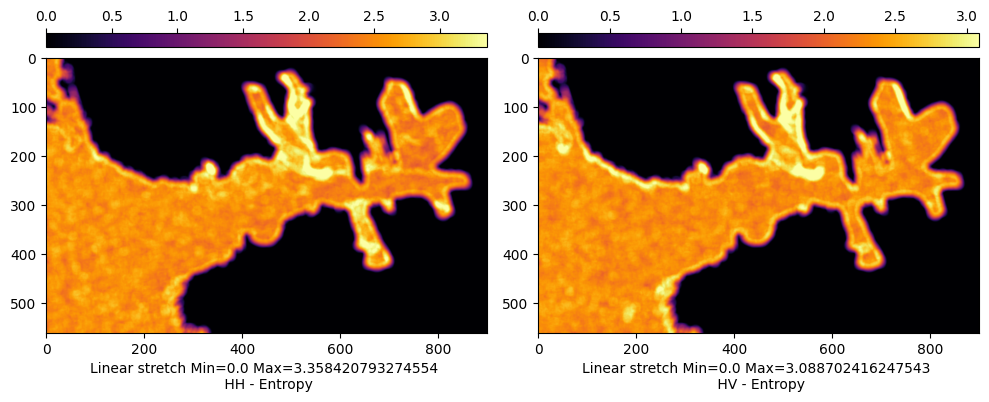

In [24]:
# fig, ax = plt.subplots(figsize=(8,8))
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1_divider = make_axes_locatable(ax1)
ax2_divider = make_axes_locatable(ax2)

vmin1 = np.nanpercentile(b2_ent, 1)
vmax1 = np.nanpercentile(b2_ent, 99)
vmin2 = np.nanpercentile(b3_ent, 1)
vmax2 = np.nanpercentile(b3_ent, 99)

ik1 = ax1.imshow(b2_ent, cmap='inferno', vmin=vmin1, vmax=vmax1, interpolation = 'bilinear') #fixes NaN problem
ik2 = ax2.imshow(b3_ent, cmap='inferno', vmin=vmin2, vmax=vmax2, interpolation = 'bilinear')

ax1.imshow(b2_ent, cmap='inferno', vmin=vmin1, vmax=vmax1, interpolation = 'bilinear') #fixes NaN problem
cax1 = ax1_divider.append_axes("top", size="5%", pad="4%")
cb1 = fig.colorbar(ik1, cax=cax1, orientation='horizontal')
cax1.xaxis.set_ticks_position("top")

ax2.imshow(b3_ent, cmap='inferno', vmin=vmin2, vmax=vmax2, interpolation = 'bilinear')
cax2 = ax2_divider.append_axes("top", size="5%", pad="4%")
cb2 = fig.colorbar(ik2, cax=cax2, orientation='horizontal')
cax2.xaxis.set_ticks_position("top")

ax1.xaxis.set_label_text('Linear stretch Min={} Max={} \n HH - Entropy'.format(vmin1, vmax1))
ax1.xaxis.set_label_position('bottom')
ax2.xaxis.set_label_text('Linear stretch Min={} Max={} \n HV - Entropy'.format(vmin2, vmax2))
ax2.xaxis.set_label_position('bottom')

plt.tight_layout()
# plt.savefig('C:/Users/jullian.williams/Desktop/HIRLOMAP/entropy.png',dpi=1500,     #resoluton  
#            bbox_inches='tight',  # Tight layout
#            pad_inches=0.1,       # Padding
#            facecolor='white',    # Background color
#            edgecolor='none',     # Edge color
#            format='png')
plt.show()


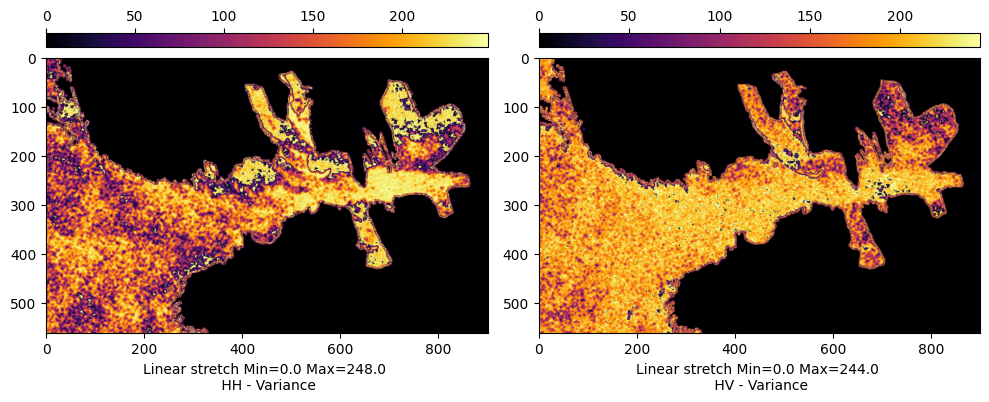

In [25]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1_divider = make_axes_locatable(ax1)
ax2_divider = make_axes_locatable(ax2)

vmin1 = np.nanpercentile(win_varHH, 1)
vmax1 = np.nanpercentile(win_varHH, 99)
vmin2 = np.nanpercentile(win_varHV, 1)
vmax2 = np.nanpercentile(win_varHV, 99)

ik3 = ax1.imshow(Image.fromarray(win_varHH.astype(np.uint8)), cmap='inferno', vmin=vmin1, vmax=vmax1, interpolation = 'bilinear') #fixes NaN problem
ik4 = ax2.imshow(Image.fromarray(win_varHV.astype(np.uint8)), cmap='inferno', vmin=vmin2, vmax=vmax2, interpolation = 'bilinear')

ax1.imshow(win_varHH, cmap='inferno', vmin=vmin1, vmax=vmax1, interpolation = 'bilinear') #fixes NaN problem
cax1 = ax1_divider.append_axes("top", size="5%", pad="4%")
cb1 = fig.colorbar(ik3, cax=cax1, orientation='horizontal')
cax1.xaxis.set_ticks_position("top")

ax2.imshow(win_varHV, cmap='inferno', vmin=vmin2, vmax=vmax2, interpolation = 'bilinear')
cax2 = ax2_divider.append_axes("top", size="5%", pad="4%")
cb2 = fig.colorbar(ik4, cax=cax2, orientation='horizontal')
cax2.xaxis.set_ticks_position("top")

ax1.xaxis.set_label_text('Linear stretch Min={} Max={} \n HH - Variance'.format(vmin1, vmax1))
ax1.xaxis.set_label_position('bottom')
ax2.xaxis.set_label_text('Linear stretch Min={} Max={} \n HV - Variance'.format(vmin2, vmax2))
ax2.xaxis.set_label_position('bottom')

plt.tight_layout()
# plt.savefig('C:/Users/jullian.williams/Desktop/HIRLOMAP/variance.png',dpi=1500,     #resoluton  
#            bbox_inches='tight',  # Tight layout
#            pad_inches=0.1,       # Padding
#            facecolor='white',    # Background color
#            edgecolor='none',     # Edge color
#            format='png')
plt.show()

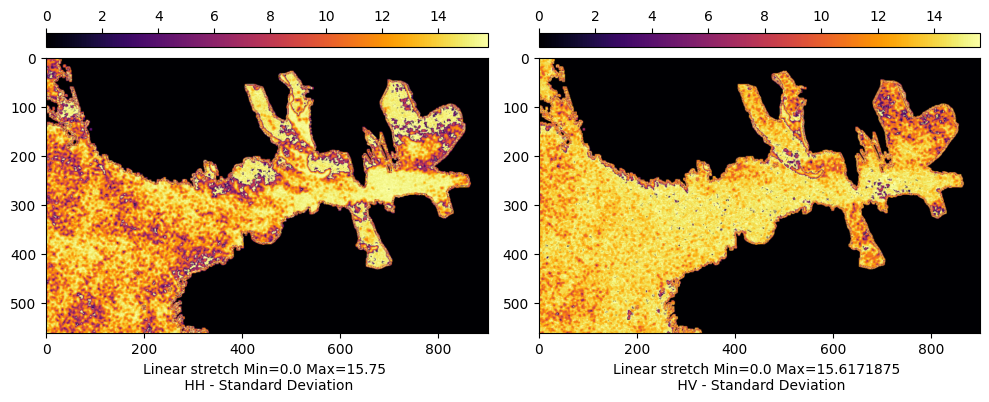

In [26]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1_divider = make_axes_locatable(ax1)
ax2_divider = make_axes_locatable(ax2)

vmin1 = np.nanpercentile(win_sdHH, 1)
vmax1 = np.nanpercentile(win_sdHH, 99)
vmin2 = np.nanpercentile(win_sdHV, 1)
vmax2 = np.nanpercentile(win_sdHV, 99)

ik5 = ax1.imshow(Image.fromarray(win_sdHH.astype(np.uint8)), cmap='inferno', vmin=vmin1, vmax=vmax1, interpolation = 'bilinear') #fixes NaN problem
ik6 = ax2.imshow(Image.fromarray(win_sdHV.astype(np.uint8)), cmap='inferno', vmin=vmin2, vmax=vmax2, interpolation = 'bilinear')

ax1.imshow(win_sdHH, cmap='inferno', vmin=vmin1, vmax=vmax1, interpolation = 'bilinear') #fixes NaN problem
cax1 = ax1_divider.append_axes("top", size="5%", pad="4%")
cb1 = fig.colorbar(ik5, cax=cax1, orientation='horizontal')
cax1.xaxis.set_ticks_position("top")

ax2.imshow(win_sdHV, cmap='inferno', vmin=vmin2, vmax=vmax2, interpolation = 'bilinear')
cax2 = ax2_divider.append_axes("top", size="5%", pad="4%")
cb2 = fig.colorbar(ik6, cax=cax2, orientation='horizontal')
cax2.xaxis.set_ticks_position("top")

ax1.xaxis.set_label_text('Linear stretch Min={} Max={} \n HH - Standard Deviation'.format(vmin1, vmax1))
ax1.xaxis.set_label_position('bottom')
ax2.xaxis.set_label_text('Linear stretch Min={} Max={} \n HV - Standard Deviation'.format(vmin2, vmax2))
ax2.xaxis.set_label_position('bottom')

plt.tight_layout()
# plt.savefig('C:/Users/jullian.williams/Desktop/HIRLOMAP/sd.png',dpi=1500,     #resoluton  
#            bbox_inches='tight',  # Tight layout
#            pad_inches=0.1,       # Padding
#            facecolor='white',    # Background color
#            edgecolor='none',     # Edge color
#            format='png')
plt.show()

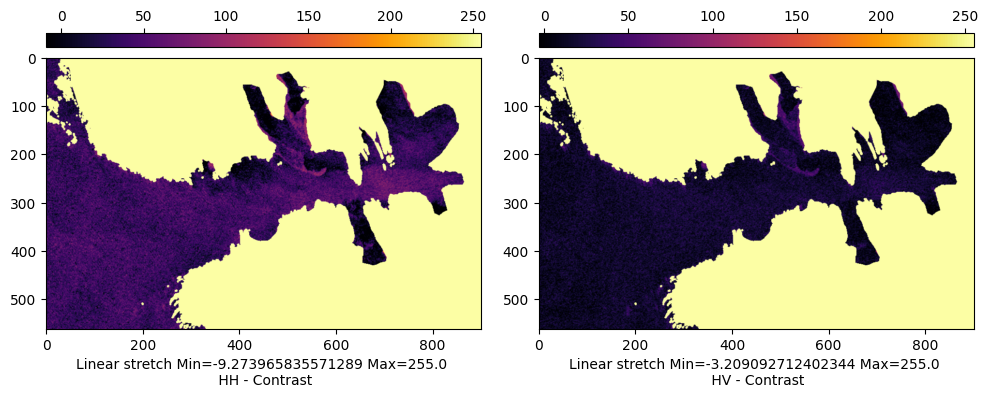

In [27]:
minvalHH = np.percentile(b2, 2)
maxvalHH = np.percentile(b2, 98)
b2_HH = np.clip(b2, minvalHH, maxvalHH)
b2_HH = ((b2 - minvalHH) / (maxvalHH - minvalHH)) *255

minvalHV = np.percentile(b3, 2)
maxvalHV = np.percentile(b3, 98)
b3_HV = np.clip(b3, minvalHV, maxvalHV)
b3_HV = ((b3 - minvalHV) / (maxvalHV  - minvalHV)) *255

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1_divider = make_axes_locatable(ax1)
ax2_divider = make_axes_locatable(ax2)

vmin1 = np.nanpercentile(b2_HH, 1)
vmax1 = np.nanpercentile(b2_HH, 99)
vmin2 = np.nanpercentile(b3_HV, 1)
vmax2 = np.nanpercentile(b3_HV, 99)

ik7 = ax1.imshow(Image.fromarray(b2_HH.astype(np.uint8)), cmap='inferno', vmin=vmin1, vmax=vmax1, interpolation = 'bilinear') 
ik8 = ax2.imshow(Image.fromarray(b3_HV.astype(np.uint8)), cmap='inferno', vmin=vmin2, vmax=vmax2, interpolation = 'bilinear')

ax1.imshow(b2_HH, cmap='inferno', vmin=vmin1, vmax=vmax1, interpolation = 'bilinear') 
cax1 = ax1_divider.append_axes("top", size="5%", pad="4%")
cb1 = fig.colorbar(ik7, cax=cax1, orientation='horizontal')
cax1.xaxis.set_ticks_position("top")

ax2.imshow(b3_HV, cmap='inferno', vmin=vmin2, vmax=vmax2, interpolation = 'bilinear')
cax2 = ax2_divider.append_axes("top", size="5%", pad="4%")
cb2 = fig.colorbar(ik8, cax=cax2, orientation='horizontal')
cax2.xaxis.set_ticks_position("top")

ax1.xaxis.set_label_text('Linear stretch Min={} Max={} \n HH - Contrast'.format(vmin1, vmax1))
ax1.xaxis.set_label_position('bottom')
ax2.xaxis.set_label_text('Linear stretch Min={} Max={} \n HV - Contrast'.format(vmin2, vmax2))
ax2.xaxis.set_label_position('bottom')

plt.tight_layout()
# plt.savefig('C:/Users/jullian.williams/Desktop/HIRLOMAP/contrast.png',dpi=1500,     #resoluton  
#            bbox_inches='tight',  # Tight layout
#            pad_inches=0.1,       # Padding
#            facecolor='white',    # Background color
#            edgecolor='none',     # Edge color
#            format='png')
plt.show()

In [57]:
b2ent8 = b2_ent.astype('uint8')
b3ent8 = b3_ent.astype('uint8')

In [60]:
prod = Image.fromarray(prod.astype(np.uint8))
rat = Image.fromarray(rat.astype(np.uint8))
varHH8 = Image.fromarray(win_varHH.astype(np.uint8))
varHV8 = Image.fromarray(win_varHV.astype(np.uint8))
sdHH8 = Image.fromarray(win_sdHH.astype(np.uint8))
sdHV8 = Image.fromarray(win_sdHV.astype(np.uint8))
contHH8 = Image.fromarray(b2_HH.astype(np.uint8))
contHV8 = Image.fromarray(b3_HV.astype(np.uint8))

C:\Users\jullian.williams\AppData\Local\Temp\ipykernel_13020\3490500173.py:2: RuntimeWarning: invalid value encountered in cast
  rat = Image.fromarray(rat.astype(np.uint8))


In [65]:
bandz = np.dstack((b1_,b2_,b3_,prod,rat,b2ent8,b3ent8,varHH8,varHV8,sdHH8,sdHV8,contHH8,contHV8))
origin = np.dstack((b3_,b2_,b1_))
calcbandsH = np.dstack((varHH8,sdHH8,contHH8))
calcbandsV = np.dstack((varHV8,sdHV8,contHV8))

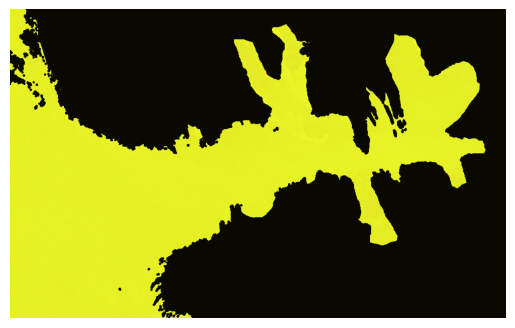

In [43]:
plt.imshow(origin)
plt.axis('off')
plt.show()

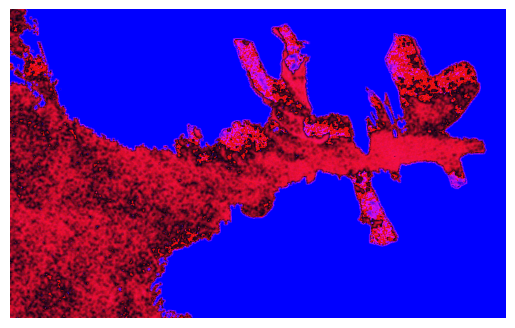

In [29]:
plt.imshow(calcbandsH)
plt.axis('off')
plt.show()

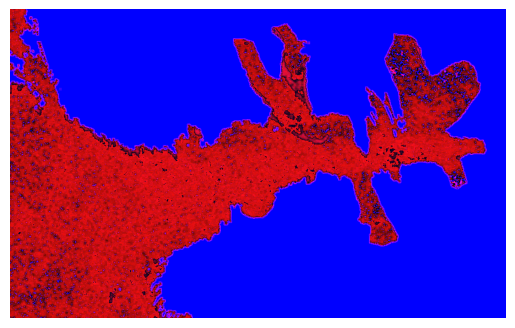

In [30]:
plt.imshow(calcbandsV)
plt.axis('off')
plt.show()

In [78]:
kwargs = src.meta
kwargs.update(
    dtype=rio.float32,
    count=13)

In [79]:
with rio.open('C:/Users/jullian.williams/Desktop/HIRLOMAP/output_bands2.tif', 'w', **kwargs) as dst:
    dst.write(bands2.astype(rio.float32))

In [75]:
# Issued?
# Do it to shove all bands into image
# bands2 = np.moveaxis(bandz.squeeze(),-1,0)
# print(bands2.shape) # check new shape, should be (num. bands, X,Y)
# print(meta)
# with rio.open("C:/Users/jullian.williams/Desktop/HIRLOMAP/output_bands.tif", "w", **meta) as dst:
#         dst.write(bands2)

## Image Classification blocks

### Support Vector Machine (3 bands)

              precision    recall  f1-score   support

           0       0.78      0.62      0.69        29
           1       0.72      0.85      0.78        33

    accuracy                           0.74        62
   macro avg       0.75      0.73      0.74        62
weighted avg       0.75      0.74      0.74        62



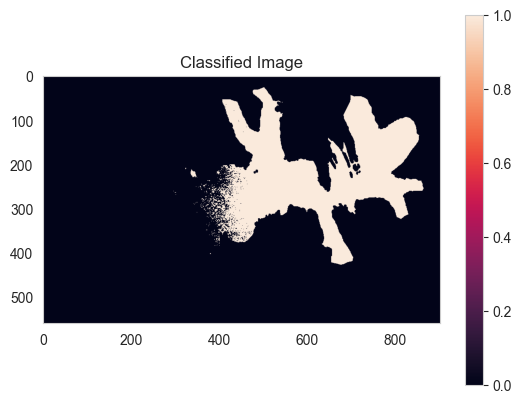

In [21]:
# Step 1: Load the raster image
# C:/Users/jullian.williams/Desktop/HIRLOMAP/output_bands.tif

raster_path = "C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/ALL_SAT/composite/RS2/3band_/RS2_SCNA_20120203_155203_ASC_001.tif"
with rio.open(raster_path) as src:
    image = src.read()  # Read all bands
    profile = src.profile  # Save metadata
    b1 = src.read(1)
    b2 = src.read(2)
    b3 = src.read(3)
    image = np.moveaxis(image, 0, -1)  # Rearrange to (rows, cols, bands)
    
    bands = np.dstack((b1,b2,b3))  # <-- Why must b1 be alpha? Odd.
    bands = bands.reshape(int(np.prod(bands.shape)/3),3)

# Step 2: Load the shapefile
shapefile_path = "C:/Users/jullian.williams/Desktop/HIRLOMAP/ROI/HS_ice_water.shp"
shapefile = gpd.read_file(shapefile_path)

# Step 3: Extract training data
# Assuming the shapefile has a 'class' column for labels
training_data = []
labels = []

for _, row in shapefile.iterrows():
    geom = row.geometry
    label = row['Class']
    mask = rio.features.geometry_mask([geom], transform=profile['transform'], invert=True, out_shape=image.shape[:2])
    pixels = image[mask]
    training_data.append(pixels)
    labels.extend([label] * len(pixels))

training_data = np.vstack(training_data)
labels = np.array(labels)

# Step 4: Train the SVM model
X_train, X_test, y_train, y_test = train_test_split(training_data, labels, test_size=0.3, random_state=42)
clf = make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-3))
clf.fit(X_train, y_train)

# Step 5: Classify the image
predicted = clf.predict(bands) #Predict using the model
class_image = predicted.reshape(b1.shape)

y_pred = clf.predict(X_test)

# Generate classification report
report = classification_report(y_test, y_pred)
print(report)

# Step 7: Save and visualize the classified image
plt.imshow(class_image)
plt.colorbar()
plt.title("Classified Image")

# plt.savefig('C:/Users/jullian.williams/Desktop/HIRLOMAP/class3b_image.png',dpi=1500,     #resoluton  
#            bbox_inches='tight',  # Tight layout
#            pad_inches=0.1,       # Padding
#            facecolor='white',    # Background color
#            edgecolor='none',     # Edge color
#            format='png')

plt.show()

### Support Vector Machine (13 bands)

              precision    recall  f1-score   support

           0       0.81      0.76      0.79        29
           1       0.80      0.85      0.82        33

    accuracy                           0.81        62
   macro avg       0.81      0.80      0.80        62
weighted avg       0.81      0.81      0.81        62



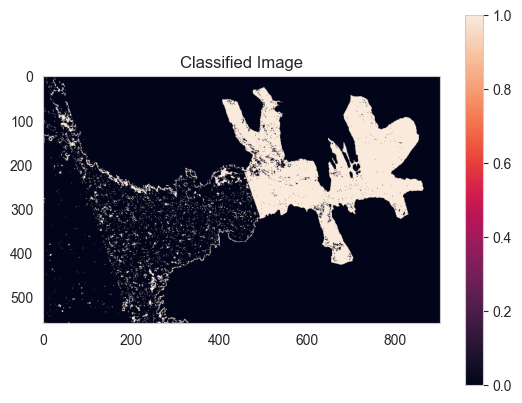

In [20]:
# C:/Users/jullian.williams/Desktop/HIRLOMAP/output_bands.tif

raster_path = "C:/Users/jullian.williams/Desktop/HIRLOMAP/output_bands2.tif"
with rio.open(raster_path) as src:
    image = src.read()  # Read all bands
    profile = src.profile  # Save metadata
    b1 = src.read(1)
    b2 = src.read(2)
    b3 = src.read(3)
    b4 = src.read(4)
    b5 = src.read(5)
    b6 = src.read(6)
    b7 = src.read(7)
    b8 = src.read(8)
    b9 = src.read(9)
    b10 = src.read(10)
    b11 = src.read(11)
    b12 = src.read(12)
    b13 = src.read(13)
    image = np.moveaxis(image, 0, -1)  # Rearrange to (rows, cols, bands)

    bands = np.dstack((b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13))  # <-- Why must b1 be alpha? Odd.
    bands = bands.reshape(int(np.prod(bands.shape)/13),13)

# Step 2: Load the shapefile
shapefile_path = "C:/Users/jullian.williams/Desktop/HIRLOMAP/ROI/HS_ice_water.shp"
shapefile = gpd.read_file(shapefile_path)

# Step 3: Extract training data
# Assuming the shapefile has a 'class' column for labels
training_data = []
labels = []

for _, row in shapefile.iterrows():
    geom = row.geometry
    label = row['Class']
    mask = rio.features.geometry_mask([geom], transform=profile['transform'], invert=True, out_shape=image.shape[:2])
    pixels = image[mask]
    training_data.append(pixels)
    labels.extend([label] * len(pixels))

training_data = np.vstack(training_data)
labels = np.array(labels)

# Step 4: Train the SVM model
X_train, X_test, y_train, y_test = train_test_split(training_data, labels, test_size=0.3, random_state=42)
clf = make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-3))
clf.fit(X_train, y_train)

# Step 5: Classify the image
predicted = clf.predict(bands) #Predict using the model
class_image = predicted.reshape(b1.shape)

y_pred = clf.predict(X_test)

# Generate classification report
report = classification_report(y_test, y_pred)
print(report)

# Step 7: Save and visualize the classified image
plt.imshow(class_image)
plt.colorbar()
plt.title("Classified Image")


# plt.savefig('C:/Users/jullian.williams/Desktop/HIRLOMAP/class_image.png',dpi=1500,     #resoluton  
#            bbox_inches='tight',  # Tight layout
#            pad_inches=0.1,       # Padding
#            facecolor='white',    # Background color
#            edgecolor='none',     # Edge color
#            format='png')

plt.show()

In [ ]:
# Compute confusion matrix using test data
cnf_matrix_sklearn = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cnf_matrix_sklearn)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix_sklearn, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# creating confusion matrix and accuracy calculation
cm = confusion_matrix(y_test,y_pred)
print(cm)
accuracy = float(cm.diagonal().sum())/len(y_test)
print('model accuracy is:',accuracy*100,'%')

### Random Forest (13 bands)

In [13]:
raster_path = "C:/Users/jullian.williams/Desktop/HIRLOMAP/output_bands2.tif"
with rio.open(raster_path) as src:
    image = src.read()  # Read all bands
    profile = src.profile  # Save metadata
    b1 = src.read(1)
    b2 = src.read(2)
    b3 = src.read(3)
    b4 = src.read(4)
    b5 = src.read(5)
    b6 = src.read(6)
    b7 = src.read(7)
    b8 = src.read(8)
    b9 = src.read(9)
    b10 = src.read(10)
    b11 = src.read(11)
    b12 = src.read(12)
    b13 = src.read(13)
    image = np.moveaxis(image, 0, -1)  # Rearrange to (rows, cols, bands)

    bands = np.dstack((b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13))  # <-- Why must b1 be alpha? Odd.
    bands = bands.reshape(int(np.prod(bands.shape)/13),13)

# Step 2: Load the shapefile
shapefile_path = "C:/Users/jullian.williams/Desktop/HIRLOMAP/ROI/HS_ice_water.shp"
shapefile = gpd.read_file(shapefile_path)

# Step 3: Extract training data
# Assuming the shapefile has a 'class' column for labels
training_data = []
labels = []

for _, row in shapefile.iterrows():
    geom = row.geometry
    label = row['Class']
    mask = rio.features.geometry_mask([geom], transform=profile['transform'], invert=True, out_shape=image.shape[:2])
    pixels = image[mask]
    training_data.append(pixels)
    labels.extend([label] * len(pixels))

training_data = np.vstack(training_data)
labels = np.array(labels)

X_train, X_test, Y_train, Y_test = train_test_split(training_data, labels, test_size=0.3, random_state=42)

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, Y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.81


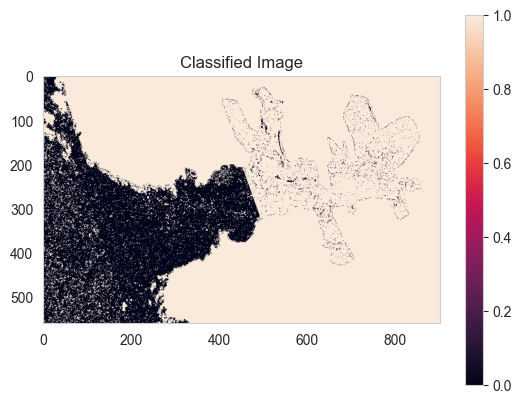

In [19]:
RF_pred = rf_classifier.predict(bands) #Predict using the model
climage = RF_pred.reshape(b1.shape)

plt.imshow(climage)
plt.colorbar()
plt.title("Classified Image")

# plt.savefig('C:/Users/jullian.williams/Desktop/HIRLOMAP/climage.png',dpi=1500,     #resoluton  
#            bbox_inches='tight',  # Tight layout
#            pad_inches=0.1,       # Padding
#            facecolor='white',    # Background color
#            edgecolor='none',     # Edge color
#            format='png')

plt.show()

### KNN (13 bands)

In [2]:
raster_path = "C:/Users/jullian.williams/Desktop/HIRLOMAP/output_bands2.tif"
with rio.open(raster_path) as src:
    image = src.read()  # Read all bands
    profile = src.profile  # Save metadata
    b1 = src.read(1)
    b2 = src.read(2)
    b3 = src.read(3)
    b4 = src.read(4)
    b5 = src.read(5)
    b6 = src.read(6)
    b7 = src.read(7)
    b8 = src.read(8)
    b9 = src.read(9)
    b10 = src.read(10)
    b11 = src.read(11)
    b12 = src.read(12)
    b13 = src.read(13)
    image = np.moveaxis(image, 0, -1)  # Rearrange to (rows, cols, bands)

    bands = np.dstack((b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13))  # <-- Why must b1 be alpha? Odd.
    bands = bands.reshape(int(np.prod(bands.shape)/13),13)

# Step 2: Load the shapefile
shapefile_path = "C:/Users/jullian.williams/Desktop/HIRLOMAP/ROI/HS_ice_water.shp"
shapefile = gpd.read_file(shapefile_path)

# Step 3: Extract training data
# Assuming the shapefile has a 'class' column for labels
training_data = []
labels = []

for _, row in shapefile.iterrows():
    geom = row.geometry
    label = row['Class']
    mask = rio.features.geometry_mask([geom], transform=profile['transform'], invert=True, out_shape=image.shape[:2])
    pixels = image[mask]
    training_data.append(pixels)
    labels.extend([label] * len(pixels))

training_data = np.vstack(training_data)
labels = np.array(labels)

X_train, X_test, Y_train, Y_test = train_test_split(training_data, labels, test_size=0.3, random_state=42)

# Initialize KNN classifier with k=3
knn = KNeighborsClassifier(n_neighbors=2)

# Train the model
knn.fit(X_train, Y_train)

# Make predictions
y_pred = knn.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.56


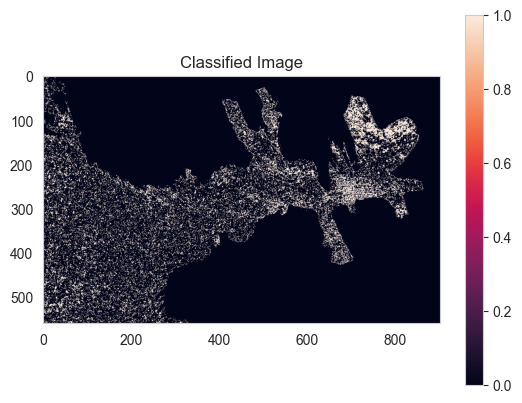

In [4]:
KNN_pred = knn.predict(bands) #Predict using the model
cimage = KNN_pred.reshape(b1.shape)

plt.imshow(cimage)
plt.colorbar()
plt.title("Classified Image")

# plt.savefig('C:/Users/jullian.williams/Desktop/HIRLOMAP/cimage.png',dpi=1500,     #resoluton  
#            bbox_inches='tight',  # Tight layout
#            pad_inches=0.1,       # Padding
#            facecolor='white',    # Background color
#            edgecolor='none',     # Edge color
#            format='png')

plt.show()

### ANN (13 bands)

#### In tensor environment

----------------------------------------------------------------------------------------

In [2]:
import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Dense

from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae

In [3]:
raster_path = "C:/Users/jullian.williams/Desktop/HIRLOMAP/output_bands2.tif"
with rio.open(raster_path) as src:
    image = src.read()  # Read all bands
    profile = src.profile  # Save metadata
    b1 = src.read(1)
    b2 = src.read(2)
    b3 = src.read(3)
    b4 = src.read(4)
    b5 = src.read(5)
    b6 = src.read(6)
    b7 = src.read(7)
    b8 = src.read(8)
    b9 = src.read(9)
    b10 = src.read(10)
    b11 = src.read(11)
    b12 = src.read(12)
    b13 = src.read(13)
    image = np.moveaxis(image, 0, -1)  # Rearrange to (rows, cols, bands)

    bands = np.dstack((b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13))  # <-- Why must b1 be alpha? Odd.
    bands = bands.reshape(int(np.prod(bands.shape)/13),13)

# Step 2: Load the shapefile
shapefile_path = "C:/Users/jullian.williams/Desktop/HIRLOMAP/ROI/HS_ice_water.shp"
shapefile = gpd.read_file(shapefile_path)

# Step 3: Extract training data
# Assuming the shapefile has a 'class' column for labels
training_data = []
labels = []

for _, row in shapefile.iterrows():
    geom = row.geometry
    label = row['Class']
    mask = rio.features.geometry_mask([geom], transform=profile['transform'], invert=True, out_shape=image.shape[:2])
    pixels = image[mask]
    training_data.append(pixels)
    labels.extend([label] * len(pixels))

training_data = np.vstack(training_data)
labels = np.array(labels)

# Step 4: Train the SVM model
X_train, X_test, Y_train, Y_test = train_test_split(training_data, labels, test_size=0.3, random_state=42)

# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [4]:
model = Sequential()

#Adding the input layer and the first hidden layer
model.add(Dense(units = 100,
                kernel_initializer = 'uniform',
                activation = 'relu',
                input_dim = 13))

#adding the second hidden layer
model.add(Dense(units = 150,
                kernel_initializer = 'uniform',
                activation = 'relu'
                ))

#addinf the third hidden layer
model.add(Dense(units=200,
                kernel_initializer = 'uniform',
                activation= 'relu'))

#adding the output layer
model.add(Dense(units=1,
                kernel_initializer = 'uniform',
                activation = 'sigmoid'))

In [5]:
model.compile(optimizer = 'adam',loss='binary_crossentropy',metrics = ['accuracy'])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1400      
                                                                 
 dense_1 (Dense)             (None, 150)               15150     
                                                                 
 dense_2 (Dense)             (None, 200)               30200     
                                                                 
 dense_3 (Dense)             (None, 1)                 201       
                                                                 
Total params: 46,951
Trainable params: 46,951
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Fitting the ANN to the training Set
EPOCHS = 100
Batch_size = 64

# train model
H= model.fit(X_train,
             Y_train,
             batch_size = Batch_size,
             epochs = EPOCHS,
             validation_split = 0.4,
             verbose=1)

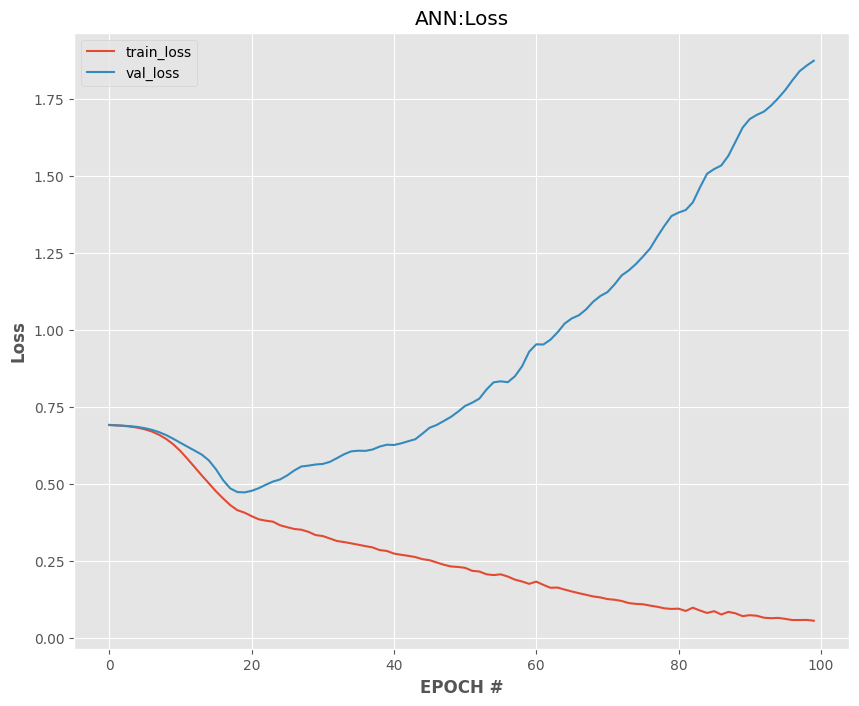

In [8]:
#plot the training and validation loss
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize=[10,8])
plt.plot(N, H.history['loss'],label ='train_loss')
plt.plot(N, H.history['val_loss'],label= 'val_loss')
plt.title("ANN:Loss")
plt.xlabel("EPOCH #",weight='bold')
plt.ylabel("Loss", weight = 'bold')
plt.legend()
plt.show()

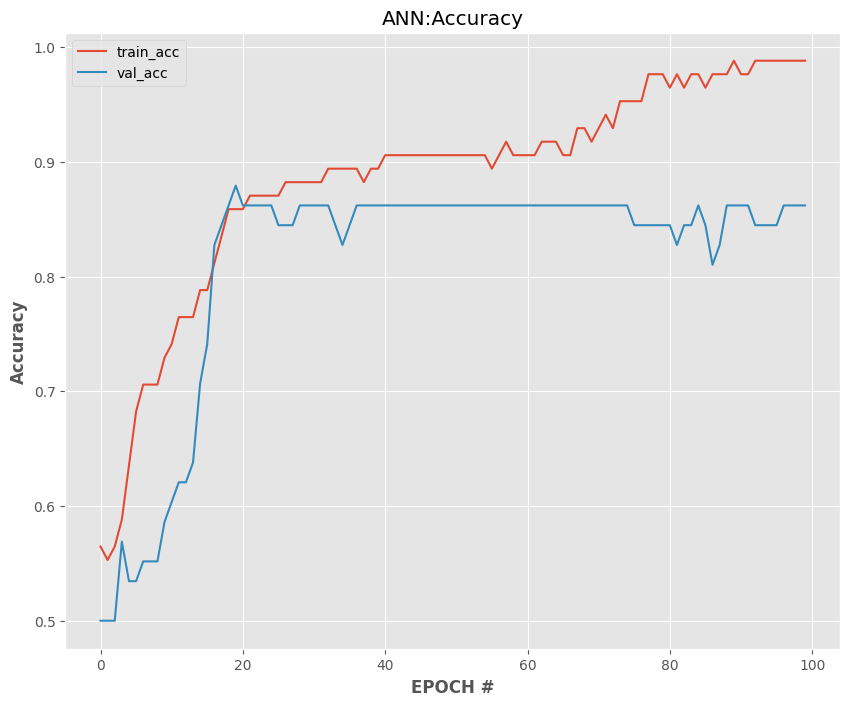

In [9]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize=[10,8])
plt.plot(N, H.history['accuracy'],label ='train_acc')
plt.plot(N, H.history['val_accuracy'],label= 'val_acc')
plt.title("ANN:Accuracy")
plt.xlabel("EPOCH #",weight='bold')
plt.ylabel("Accuracy", weight = 'bold')
plt.legend()
plt.show()

In [10]:
y_pred= model.predict(X_test)
y_pred =(y_pred >0.5)

print('*'*20)
score,acc =model.evaluate(X_test, Y_test,batch_size=10)

print("Test Score :",score)
print("Test accuracy :",acc)

2/2 [==============================] - 0s 0s/step
********************
7/7 [==============================] - 0s 3ms/step - loss: 2.0975 - accuracy: 0.7742
Test Score : 2.097461223602295
Test accuracy : 0.774193525314331


In [11]:
cfm=confusion_matrix(Y_test,y_pred)
print(cfm)

print("Classification report: ")

print(classification_report(Y_test,y_pred))

acc=accuracy_score(Y_test, y_pred)
print("Accuracy of the model: ",acc)

[[19 10]
 [ 4 29]]
Classification report: 
              precision    recall  f1-score   support

           0       0.83      0.66      0.73        29
           1       0.74      0.88      0.81        33

    accuracy                           0.77        62
   macro avg       0.78      0.77      0.77        62
weighted avg       0.78      0.77      0.77        62

Accuracy of the model:  0.7741935483870968


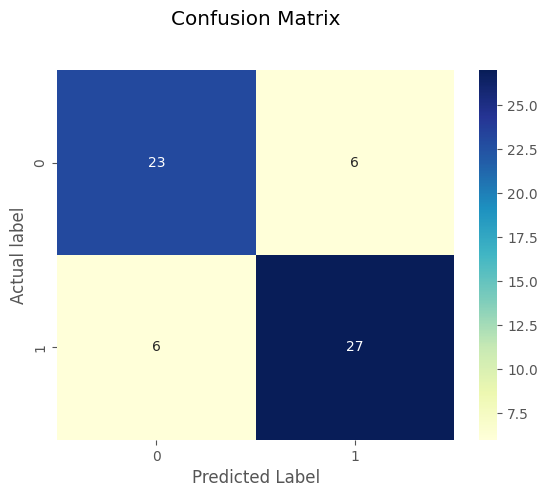

In [55]:
p = sns.heatmap (pd.DataFrame(cfm), annot= True, cmap ="YlGnBu", fmt='g')
plt.title("Confusion Matrix", y=1.1)
plt.ylabel("Actual label")
plt.xlabel("Predicted Label")
plt.show(p)

In [12]:
ANN_pred = model.predict(bands) #Predict using the model
clsimage = ANN_pred.reshape(b1.shape)

15796/15796 [==============================] - 12s 734us/step


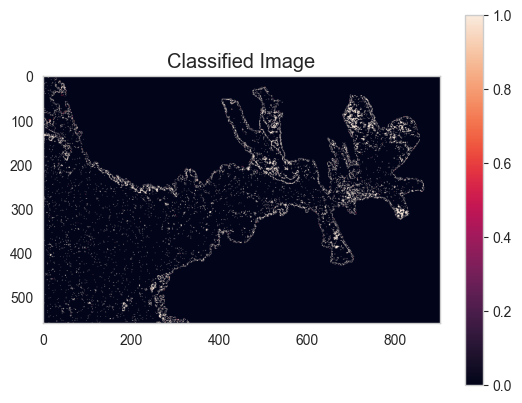

In [13]:
sns.set_style("whitegrid", {'axes.grid' : False})
plt.imshow(clsimage)
plt.colorbar()
plt.title("Classified Image")

# plt.savefig('C:/Users/jullian.williams/Desktop/HIRLOMAP/clsimage.png',dpi=1500,     #resoluton  
#            bbox_inches='tight',  # Tight layout
#            pad_inches=0.1,       # Padding
#            facecolor='white',    # Background color
#            edgecolor='none',     # Edge color
#            format='png')

plt.show()

------------------------------------------------------------------------------------------------------------------------------------

## References:

https://github.com/SnehaShukla937/SupportVectorMachine/tree/master

https://github.com/Kamrrann/Sentinel2_Classification_Using_Deep-Convolutional-Neural-Network/tree/main

https://github.com/kunsan1/Classification-Using-ANN/blob/main/Kunal_Sangale_ANN_Model.ipynb